In [2]:
import pandas as pd
df=pd.read_csv('/kaggle/input/algo-trading-data-nifty-100-data-with-indicators/TITAN_10minute_data.csv',na_values=['null'],
               index_col='date',parse_dates=True,infer_datetime_format=True)
df.head()

/tmp/ipykernel_47/2948999588.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df=pd.read_csv('/kaggle/input/algo-trading-data-nifty-100-data-with-indicators/TITAN_10minute_data.csv',na_values=['null'],


,Unnamed: 0,close,high,low,open,volume
date,,,,,,
2015-02-02 09:15:00+05:30,0,429.60,430.00,428.00,428.0,22641
2015-02-02 09:25:00+05:30,1,434.50,436.00,429.35,429.6,48179
2015-02-02 09:35:00+05:30,2,432.50,435.55,432.50,434.5,21981
2015-02-02 09:45:00+05:30,3,434.10,434.10,432.05,432.5,27808
2015-02-02 09:55:00+05:30,4,433.15,434.40,433.00,434.0,12683


# **EDA**

In [3]:
df.shape

(65928, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65928 entries, 2015-02-02 09:15:00+05:30 to 2022-10-21 15:25:00+05:30
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  65928 non-null  int64  
 1   close       65928 non-null  float64
 2   high        65928 non-null  float64
 3   low         65928 non-null  float64
 4   open        65928 non-null  float64
 5   volume      65928 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 3.5 MB


In [5]:
df.isna().sum()

Unnamed: 0    0
close         0
high          0
low           0
open          0
volume        0
dtype: int64

# **Data Preprocessing**

In [6]:
df['price'] = ((df['close']+df['high']+df['low'])/3)
df['Cumulative_Price_Volume'] = (df['price'] * df['volume']).cumsum()
df['Cumulative_Volume'] = df['volume'].cumsum()
df['VWAP'] = df['Cumulative_Price_Volume'] / df['Cumulative_Volume']
print(df)

                           Unnamed: 0    close     high      low     open  \
date                                                                        
2015-02-02 09:15:00+05:30           0   429.60   430.00   428.00   428.00   
2015-02-02 09:25:00+05:30           1   434.50   436.00   429.35   429.60   
2015-02-02 09:35:00+05:30           2   432.50   435.55   432.50   434.50   
2015-02-02 09:45:00+05:30           3   434.10   434.10   432.05   432.50   
2015-02-02 09:55:00+05:30           4   433.15   434.40   433.00   434.00   
...                               ...      ...      ...      ...      ...   
2022-10-21 14:45:00+05:30       65923  2653.65  2659.00  2652.00  2658.95   
2022-10-21 14:55:00+05:30       65924  2656.45  2660.00  2649.00  2653.65   
2022-10-21 15:05:00+05:30       65925  2666.85  2670.00  2656.35  2656.45   
2022-10-21 15:15:00+05:30       65926  2668.80  2671.00  2663.70  2666.50   
2022-10-21 15:25:00+05:30       65927  2670.65  2671.10  2658.65  2668.65   

<Axes: xlabel='date'>

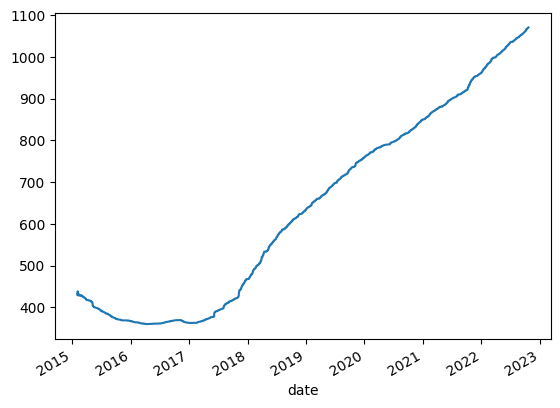

In [7]:
df['VWAP'].plot()

In [8]:
# Set Target Variable
output_var = pd.DataFrame(df['VWAP'])
#Selecting the Features
features = ['open', 'high', 'low', 'volume']

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,open,high,low,volume
date,,,,
2015-02-02 09:15:00+05:30,0.053555,0.053386,0.053996,0.002752
2015-02-02 09:25:00+05:30,0.054209,0.055828,0.054549,0.005856
2015-02-02 09:35:00+05:30,0.056210,0.055645,0.055839,0.002672
2015-02-02 09:45:00+05:30,0.055393,0.055055,0.055655,0.003380
2015-02-02 09:55:00+05:30,0.056006,0.055177,0.056044,0.001542


In [10]:
from sklearn.model_selection import TimeSeriesSplit
# Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=10) # 90-10%
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [11]:
print(X_train.shape)
print(X_test.shape)

(59935, 4)
(5993, 4)


In [12]:
# Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])
print(X_train.shape)
print(X_test.shape)

(59935, 1, 4)
(5993, 1, 4)


# **Applying LSTM Model**

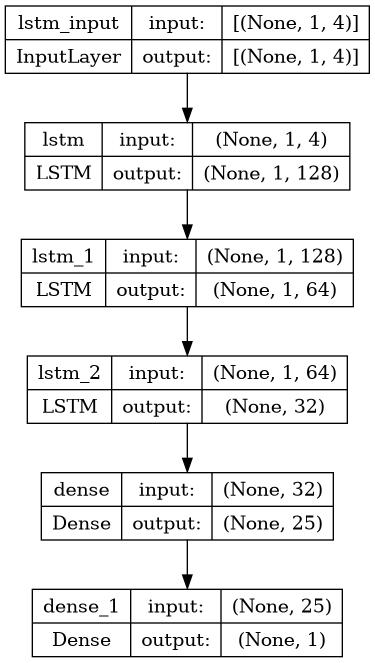

In [13]:
# Building the LSTM Model
import tensorflow as tf
lstm = tf.keras.Sequential()
lstm.add(tf.keras.layers.LSTM(128, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=True))
lstm.add(tf.keras.layers.LSTM(64, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=True))
lstm.add(tf.keras.layers.LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(tf.keras.layers.Dense(25))
lstm.add(tf.keras.layers.Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
tf.keras.utils.plot_model(lstm, show_shapes=True, show_layer_names=True)

In [14]:
# Model Training
history=lstm.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1, shuffle=False)

Epoch 1/10
3746/3746 [==============================] - 25s 5ms/step - loss: 6522.6533
Epoch 2/10
3746/3746 [==============================] - 21s 6ms/step - loss: 414.8531
Epoch 3/10
3746/3746 [==============================] - 21s 6ms/step - loss: 236.8418
Epoch 4/10
3746/3746 [==============================] - 21s 5ms/step - loss: 157.1943
Epoch 5/10
3746/3746 [==============================] - 21s 6ms/step - loss: 115.0589
Epoch 6/10
3746/3746 [==============================] - 20s 5ms/step - loss: 90.9323
Epoch 7/10
3746/3746 [==============================] - 20s 5ms/step - loss: 78.3892
Epoch 8/10
3746/3746 [==============================] - 20s 5ms/step - loss: 72.4416
Epoch 9/10
3746/3746 [==============================] - 20s 5ms/step - loss: 69.4551
Epoch 10/10
3746/3746 [==============================] - 20s 5ms/step - loss: 67.9770


In [15]:
#LSTM Prediction
y_pred= lstm.predict(X_test)

188/188 [==============================] - 1s 3ms/step


In [16]:
from sklearn.metrics import mean_squared_error

# Make predictions using the trained model
predictions = lstm.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

188/188 [==============================] - 1s 3ms/step
Mean Squared Error: 5968.4075172245975


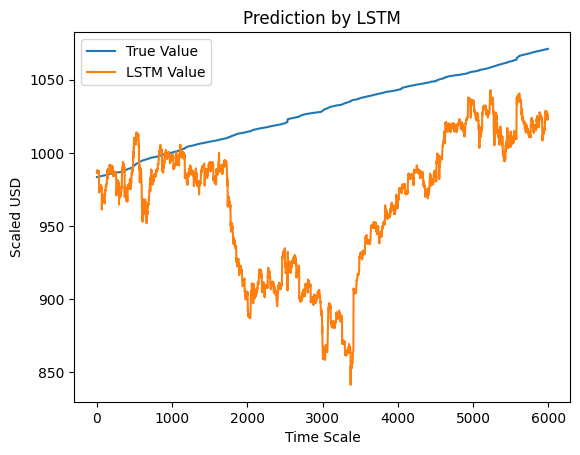

In [17]:
#Predicted vs True Close Value – LSTM
import matplotlib.pyplot as plt
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()